<a href="https://colab.research.google.com/github/Adrita2211/ML_Project/blob/main/multi_touch_point.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [14]:
clickStreamData = pd.read_excel("/content/sample_data/click_stream_new.xlsx", engine='openpyxl')

In [15]:
df = pd.DataFrame(clickStreamData)

In [16]:
df.head()

,session_id,event_name,event_time,event_id,traffic_source,event_metadata
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,"{'product_id': 15315, 'quantity': 4, 'item_pri..."
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,{'payment_status': 'Success'}


In [17]:
# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])


In [18]:
df = df.sort_values(['session_id', 'event_time'])

In [21]:
# Extract metadata if needed (optional)
def parse_metadata(meta_str):
    try:
        if pd.isna(meta_str):
            return {}
        return ast.literal_eval(meta_str)
    except:
        return {}

In [22]:
df['event_metadata'] = df['event_metadata'].apply(parse_metadata)

In [23]:
## Step 2: Create Transition Matrix
# Initialize a dictionary to count transitions
transition_counts = defaultdict(lambda: defaultdict(int))

In [24]:
# Group by session and collect event sequences
for session_id, group in df.groupby('session_id'):
    events = group['event_name'].tolist()
    for i in range(len(events) - 1):
        from_state = events[i]
        to_state = events[i + 1]
        transition_counts[from_state][to_state] += 1

In [25]:
# Get all unique states
states = sorted(df['event_name'].unique())

In [26]:
# Create transition matrix DataFrame
transition_matrix = pd.DataFrame(np.zeros((len(states), len(states))),
                               index=states, columns=states)


In [27]:
# Populate the matrix with counts
for from_state, to_states in transition_counts.items():
    for to_state, count in to_states.items():
        transition_matrix.loc[from_state, to_state] = count

In [28]:
# Convert counts to probabilities
transition_prob = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
transition_prob = transition_prob.fillna(0)  # Replace NaN with 0 for states with no outgoing transitions

print("Transition Probability Matrix:")
print(transition_prob)


Transition Probability Matrix:
             ADD_PROMO  ADD_TO_CART   BOOKING     CLICK  HOMEPAGE  \
ADD_PROMO     0.000000     0.044580  0.108224  0.251675  0.125103   
ADD_TO_CART   0.049257     0.163060  0.065898  0.220234  0.101473   
BOOKING       0.000000     0.000000  0.000000  0.191938  0.330852   
CLICK         0.031687     0.090040  0.074038  0.234878  0.131517   
HOMEPAGE      0.015813     0.219676  0.039182  0.192308  0.152739   
ITEM_DETAIL   0.025532     0.091044  0.071955  0.229124  0.144142   
PROMO_PAGE    0.035809     0.088881  0.070275  0.230713  0.142991   
SCROLL        0.029464     0.084993  0.070632  0.233205  0.139187   
SEARCH        0.029824     0.083667  0.073403  0.235224  0.135168   

             ITEM_DETAIL  PROMO_PAGE    SCROLL    SEARCH  
ADD_PROMO       0.107723    0.071958  0.169504  0.121233  
ADD_TO_CART     0.108894    0.047703  0.140511  0.102969  
BOOKING         0.136322    0.059630  0.183742  0.097516  
CLICK           0.112636    0.051685  0.15

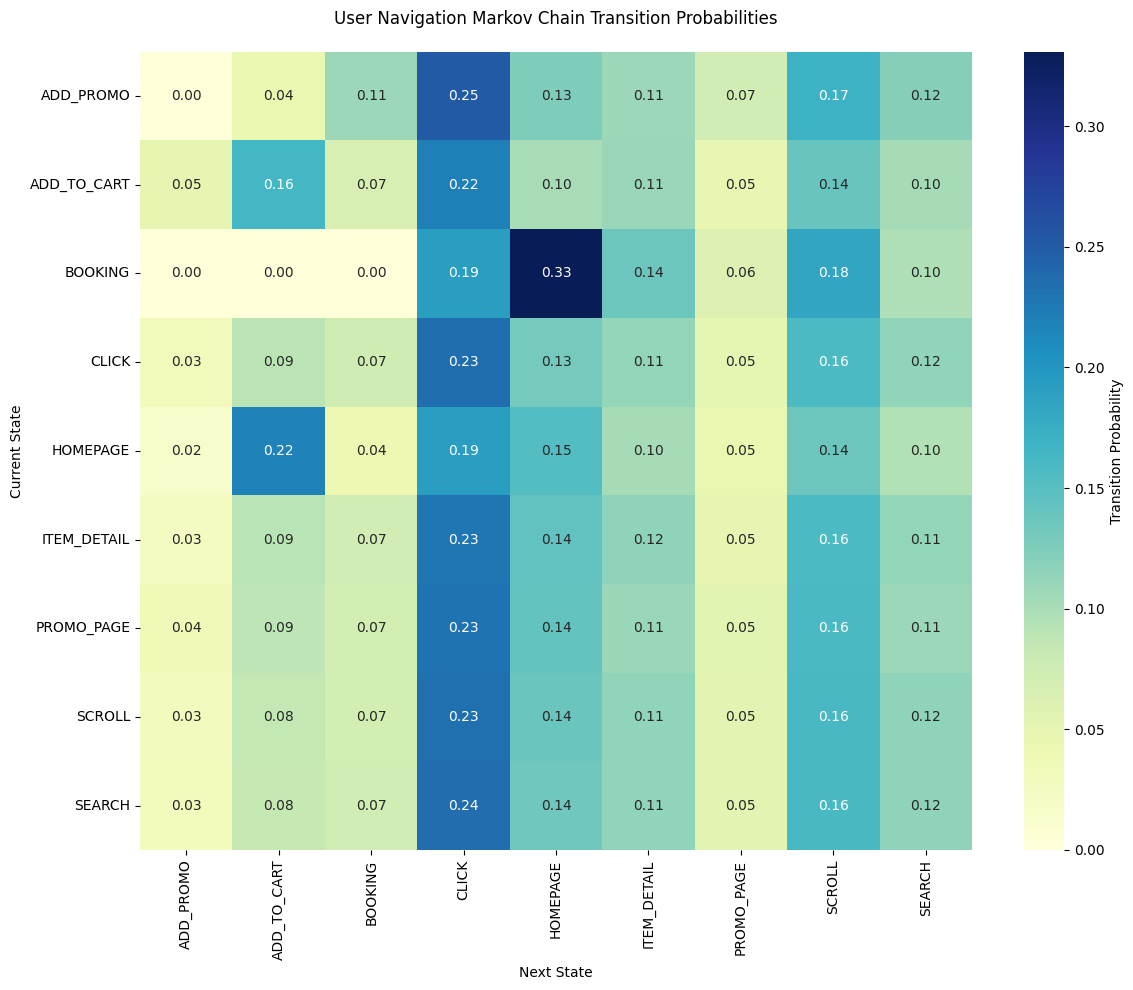

In [29]:
## Step 3: Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(transition_prob, annot=True, cmap='YlGnBu', fmt='.2f',
            cbar_kws={'label': 'Transition Probability'})
plt.title('User Navigation Markov Chain Transition Probabilities', pad=20)
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.tight_layout()
plt.show()

In [31]:

# Starting probabilities
start_probs = df.groupby('session_id').first()['event_name'].value_counts(normalize=True)
print("\nStarting Event Probabilities:")
print(start_probs)



Starting Event Probabilities:
event_name
HOMEPAGE    1.0
Name: proportion, dtype: float64


In [32]:
# Ending probabilities
end_probs = df.groupby('session_id').last()['event_name'].value_counts(normalize=True)
print("\nEnding Event Probabilities:")
print(end_probs)


Ending Event Probabilities:
event_name
BOOKING        0.808338
HOMEPAGE       0.060701
CLICK          0.038391
SCROLL         0.036935
ITEM_DETAIL    0.025827
SEARCH         0.018731
PROMO_PAGE     0.010613
ADD_TO_CART    0.000465
Name: proportion, dtype: float64


In [33]:
# Conversion rate to BOOKING
total_sessions = df['session_id'].nunique()
booking_sessions = df[df['event_name'] == 'BOOKING']['session_id'].nunique()
conversion_rate = booking_sessions / total_sessions
print(f"\nConversion Rate to Booking: {conversion_rate:.2%}")


Conversion Rate to Booking: 99.36%


In [34]:
## Step 5: Path Analysis
def find_common_paths(target_state, max_path_length=5):
    """Find all paths leading to the target state"""
    paths = defaultdict(int)

    for session_id, group in df.groupby('session_id'):
        events = group['event_name'].tolist()
        if target_state in events:
            target_index = events.index(target_state)
            path = events[max(0, target_index - max_path_length + 1):target_index + 1]
            paths[tuple(path)] += 1

    # Sort by frequency
    sorted_paths = sorted(paths.items(), key=lambda x: x[1], reverse=True)
    return sorted_paths

In [35]:
print("\nMost Common Paths to Booking:")
for path, count in find_common_paths('BOOKING')[:5]:  # Top 5 paths
    print(f"{' → '.join(path)} (count: {count})")


Most Common Paths to Booking:
HOMEPAGE → ADD_TO_CART → CLICK → BOOKING (count: 872)
HOMEPAGE → CLICK → ADD_TO_CART → BOOKING (count: 787)
ADD_TO_CART → ADD_TO_CART → ADD_TO_CART → ADD_TO_CART → BOOKING (count: 746)
HOMEPAGE → SCROLL → ADD_TO_CART → BOOKING (count: 535)
HOMEPAGE → ADD_TO_CART → SCROLL → BOOKING (count: 535)


In [36]:
##  Path Analysis
def build_conversion_funnel(start_state, target_state):
    """Build a conversion funnel from start to target state"""
    funnel = defaultdict(int)
    total_from_start = 0

    for session_id, group in df.groupby('session_id'):
        events = group['event_name'].tolist()
        if start_state in events and target_state in events:
            start_index = events.index(start_state)
            target_index = events.index(target_state)
            if start_index < target_index:
                total_from_start += 1
                path = events[start_index:target_index + 1]
                for i in range(len(path)):
                    state = path[i]
                    funnel[state] += 1

    # Calculate conversion rates at each step
    if total_from_start > 0:
        funnel = {k: v/total_from_start for k, v in funnel.items()}

    return funnel


In [37]:
booking_funnel = build_conversion_funnel('HOMEPAGE', 'BOOKING')
print("\nConversion Funnel from HOMEPAGE to BOOKING:")
for state, rate in booking_funnel.items():
    print(f"{state}: {rate:.2%}")



Conversion Funnel from HOMEPAGE to BOOKING:
HOMEPAGE: 250.62%
ADD_TO_CART: 185.25%
CLICK: 311.54%
ITEM_DETAIL: 146.84%
SCROLL: 204.33%
BOOKING: 100.00%
SEARCH: 151.30%
ADD_PROMO: 43.51%
PROMO_PAGE: 67.41%


In [40]:
# Save transition matrix to CSV
transition_prob.to_csv('markov_transition_matrix.csv')

# Save key metrics to a text file
with open('markov_analysis_results.txt', 'w') as f:
    f.write("=== Markov Chain Analysis Results ===\n\n")
    f.write("Transition Probability Matrix:\n")
    f.write(transition_prob.to_string())
    f.write("\n\nStarting Probabilities:\n")
    f.write(start_probs.to_string())
    f.write("\n\nEnding Probabilities:\n")
    f.write(end_probs.to_string())
    f.write(f"\n\nConversion Rate to Booking: {conversion_rate:.2%}")